# DigiCam: Towards High-Quality Lensless Imaging with a Low-Cost Programmable Mask

In this notebook, we visualize results for the paper "DigiCam: Towards High-Quality Lensless Imaging with a Low-Cost Programmable Mask"

In [1]:
from lensless.recon.model_dict import model_dict, download_model

CAMERA = "digicam"
DATASET = "celeba_26k"
torch_device = "cuda:1"   # for computations in this notebook

# all models stored in this dictionary
models_dict = model_dict[CAMERA][DATASET]

# PSFs (TODO more programmatic way to do this, e.g. download from Hugging Face)
measured_psf_path = "/home/bezzam/LenslessPiCam/rpi_hq_adafruit_psf_2mm/raw_data_rgb.png"
simulated_psf_path = "/home/bezzam/LenslessPiCam/outputs/2023-10-25/09-40-03/adafruit_random_pattern_20231004_174047_SIM_psf.png"
adafruit_mask_pattern = "adafruit_random_pattern_20231004_174047.npy"

/home/bezzam/anaconda3/envs/lensless/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's load the dataset used in the paper. We'll "tie" the dataset to the simulated PSF.

In [2]:
import torch
import numpy as np
import os
from lensless.utils.dataset import DigiCamCelebA
import yaml

# -- load dataset configuration common to all models 
model_path = download_model(camera=CAMERA, dataset=DATASET, model="unrolled_admm10")
config_path = os.path.join(model_path, ".hydra", "config.yaml")
with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)

# -- set seed
seed = config["seed"]
torch.manual_seed(seed)
np.random.seed(seed)
generator = torch.Generator().manual_seed(seed)

# -- use simulate PSF
psf_path = simulated_psf_path
if not os.path.exists(psf_path):
    raise FileNotFoundError("PSF file not found")

# load dataset
dataset = DigiCamCelebA(
    data_dir=config["files"]["dataset"],
    celeba_root=config["files"]["celeba_root"],
    psf_path=psf_path,
    downsample=config["files"]["downsample"],
    simulation_config=config["simulation"],
    crop=config["files"]["crop"],
    vertical_shift=config["files"]["vertical_shift"],
    horizontal_shift=config["files"]["horizontal_shift"],
)
dataset.psf = dataset.psf.to(torch_device)
print(f"Data shape :  {dataset[0][0].shape}")

# -- train-test split
train_size = int((1 - config["files"]["test_size"]) * len(dataset))
test_size = len(dataset) - train_size
_, test_set = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=generator
)
print("Test set size: ", len(test_set))

Data shape :  torch.Size([1, 380, 507, 3])
Test set size:  3900


Let's also load the measured PSF as we will be using it in the first experiment.

In [3]:
from lensless.utils.io import load_psf

# load PSF
measured_psf, background = load_psf(
    measured_psf_path,
    downsample=config["files"]["downsample"] * 4,  # PSF is 4x the resolution of the images
    return_float=True,
    return_bg=True,
    flip=True,
    bg_pix=(0, 15),
)
measured_psf = torch.from_numpy(measured_psf).to(torch_device)
assert measured_psf.shape == dataset.psf.shape

The PSF was simulated with the following script/command:

```
python scripts/sim/digicam_psf.py sim.waveprop=False \
    digicam.pattern=adafruit_random_pattern_20231004_174047.npy \
    digicam.psf=rpi_hq_adafruit_psf_2mm/raw_data_rgb.png \
    digicam.gamma=2.2 \
    digicam.ap_center=[58,76] \
    digicam.ap_shape=[19,25] \
    digicam.rotate=0 \
    digicam.horizontal_shift=-60 \
    digicam.vertical_shift=-80
```

where `digicam.pattern` is the pattern programmed to the LCD with `digicam.ap_center` and `digicam.ap_shape` used to zero-out the LCD pixels that don't overlap with the sensor.

`digicam.psf` is the PSF measured with the RPi HQ camera, and we pass it to the script to best determine `digicam.rotate`, `digicam.horizontal_shift` and `digicam.vertical_shift` to align the simulated and measured PSF (this only has to be done once).

Below is a comparison plot of the two PSFs (produced by the script above).

![PSF comparison](digicam_psf_comparison.png)

Pixels are aligned, but we see clear color differences which will be also evident in the reconstructed images below.

## Section 4.1 (ADMM, measured vs. simulated PSF)

The purpose of this experiment is to show that it is equivalent to use a measured PSF or a simulated PSF for image reconstruction with DigiCam. In both cases, reconstructions are done on a **measured** dataset.

The following results are obtained with the following scripts/commands:
    
    
```bash
# ADMM with measured PSF
python scripts/eval/benchmark_recon.py \
  n_iter_range=[10,100] \
  algorithms=[ADMM] \
  dataset=DigiCamCelebA \
  files.downsample=2

# ADMM with simulated PSF
python scripts/eval/benchmark_recon.py \
  n_iter_range=[10,100] \
  algorithms=[ADMM] \
  dataset=DigiCamCelebA \
  files.downsample=2 \
  files.psf=outputs/2023-10-25/09-40-03/adafruit_random_pattern_20231004_174047_SIM_psf.png

```

In [4]:
from pprint import pprint
import os, json


model_paths = {
    "Measured PSF": "admm_measured_psf",
    "Simulated PSF": "admm_simulated_psf",
}
psfs = {
    "Measured PSF": measured_psf,
    "Simulated PSF": dataset.psf,
}

# set model paths (and download if necessary)
for _model in model_paths.keys():

    model_key= model_paths[_model]
    # overwrite with model path
    model_paths[_model] = download_model(camera=CAMERA, dataset=DATASET, model=model_key)

print("MODEL PATHS:")
pprint(model_paths)

"""
Print desired metrics.
"""
selected_iterations = [100, 10]    # [10, 20, 100]
selected_metrics = ["PSNR", "SSIM", "LPIPS_Vgg"]
configs = dict()

for key, value in model_paths.items():

    print("-" * 80)
    print(f"{key}")
    print("-" * 80)

    # -- load results
    _results_path = os.path.join(value, "results.json")
    assert os.path.exists(_results_path), f"Path {_results_path} does not exist"
    _test_metrics = json.load(open(_results_path))["ADMM"]

    # -- load config (for reconstruction below)
    config_path = os.path.join(value, ".hydra", "config.yaml")
    with open(config_path, "r") as stream:
        configs[key] = yaml.safe_load(stream)

    # print results for each iteration
    for iteration in selected_iterations:
        print(f"{iteration} iterations")
        print("-" * 20)
        for metric in selected_metrics:
            print(f"{metric}: {_test_metrics[str(iteration)][metric]:.3}")
        print("\n")

MODEL PATHS:
{'Measured PSF': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/admm_measured_psf',
 'Simulated PSF': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/admm_simulated_psf'}
--------------------------------------------------------------------------------
Measured PSF
--------------------------------------------------------------------------------
100 iterations
--------------------
PSNR: 9.31
SSIM: 0.292
LPIPS_Vgg: 0.698


10 iterations
--------------------
PSNR: 8.7
SSIM: 0.221
LPIPS_Vgg: 0.746


--------------------------------------------------------------------------------
Simulated PSF
--------------------------------------------------------------------------------
100 iterations
--------------------
PSNR: 9.98
SSIM: 0.343
LPIPS_Vgg: 0.746


10 iterations
--------------------
PSNR: 9.3
SSIM: 0.27
LPIPS_Vgg: 0.78




Let's compare reconstructions.

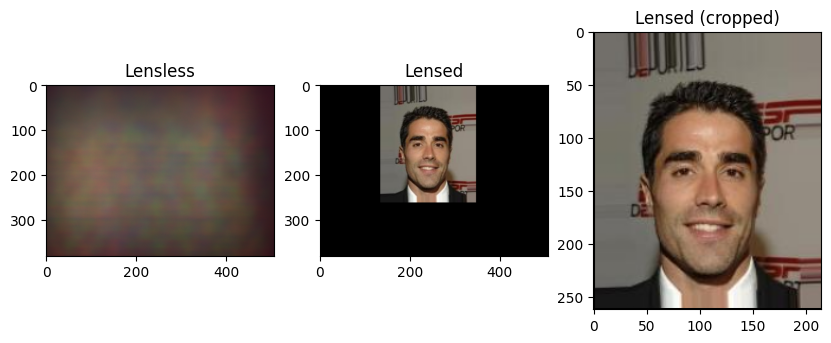

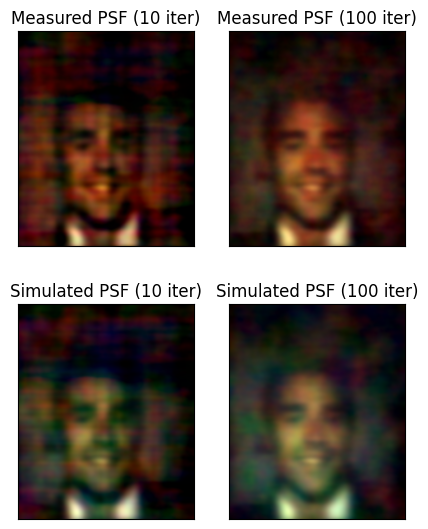

In [5]:
from lensless import ADMM
import matplotlib.pyplot as plt
from lensless.utils.plot import plot_image

idx = 4
n_iter_vals = [10, 100]   # can change these values as reconstruction computed on-the-fly!
lensless, lensed = test_set[idx]
recon = dict()   # store reconstructions

# extract region of interest
crop = dataset.crop
lensed = lensed.squeeze()
if crop is not None:
    lensed_cropped = lensed[
        ...,
        crop["vertical"][0] : crop["vertical"][1],
        crop["horizontal"][0] : crop["horizontal"][1],
        :,
    ]

# loop over algorithms and number of iterations
for algo, config in configs.items():

    recon[algo] = dict()

    # load algorithm
    psf = psfs[algo]
    admm = ADMM(
        psf,
        mu1=config["admm"]["mu1"],
        mu2=config["admm"]["mu2"],
        mu3=config["admm"]["mu3"],
        tau=config["admm"]["tau"],
    )

    # applying algorithm
    for n_iter in n_iter_vals:

        # -- reconstruct
        admm.set_data(lensless.to(torch_device))
        _recon = admm.apply(n_iter=n_iter, plot=False)

        # -- extract region of interest
        _recon = _recon.reshape(-1, *_recon.shape[-3:]).movedim(-1, -3)
        if crop is not None:
            _recon = _recon[
                ...,
                crop["vertical"][0] : crop["vertical"][1],
                crop["horizontal"][0] : crop["horizontal"][1],
            ]
        _recon = _recon.cpu().numpy().squeeze()
        _recon = np.moveaxis(_recon, 0, -1)

        # -- save
        recon[algo][n_iter] = _recon

        admm.reset()

# plot
# -- lensless and lensed
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(lensless.cpu().numpy().squeeze())
ax[0].set_title("Lensless")
ax[1].imshow(lensed)
ax[1].set_title("Lensed")
ax[2].imshow(lensed_cropped)
ax[2].set_title("Lensed (cropped)")

# -- reconstructions
fig, ax = plt.subplots(len(configs.keys()), len(n_iter_vals), figsize=(5, 6.5))
for i, algo in enumerate(configs.keys()):
    for j, n_iter in enumerate(n_iter_vals):
        plot_image(recon[algo][n_iter], ax=ax[i, j])
        ax[i, j].set_title(f"{algo} ({n_iter} iter)")
        # remove ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])


As seen by metrics and the example outputs, reconstruction quality is similar when using a simulated or measured PSF for reconstruction. This is great news because we can avoid this extra calibration step of measured a PSF (which is quite finicky) and use a simulated PSF instead.

Biggest difference is in the coloring, as we don't have the specification on the color filters for the sensor to properly simulate them for the PSF. Nevertheless, color correction is an open problem in lensless imaging, and even with the measured PSF, the colors are not great. As color correction is not the focus of this paper, and we leave it for future work.

Let's see below how the PSF can be simulated when we know the pattern programmed on the mask.

## Section 4.2 (Physics-based machine learning)

The purpose of this experiment is to show that the physics-based machine learning reconstructions (with a simulated PSF) can improve image quality compared to the ADMM reconstructions. We use the same **measured dataset** as in the previous experiment.

In [6]:
from pprint import pprint
from matplotlib import pyplot as plt
import os
import json
import numpy as np


model_paths = {
    "US10": "unrolled_admm10",
    "FUS10": "unrolled_admm10_ft_psf",
    "U-Net": "unet8M",
    "US10+P8": "unrolled_admm10_post8M",
    "FUS10+P8": "unrolled_admm10_ft_psf_post8M",
    "P8+US10": "pre8M_unrolled_admm10",
    "P4+US10+P4": "pre4M_unrolled_admm10_post4M",
    "P4+FUS10+P4": "pre4M_unrolled_admm10_ft_psf_post4M",
}

# set model paths (and download if necessary)
for _model in model_paths.keys():
    model_key= model_paths[_model]
    # overwrite with model path
    model_paths[_model] = download_model(camera=CAMERA, dataset=DATASET, model=model_key)

print("MODEL PATHS:")
pprint(model_paths)

MODEL PATHS:
{'FUS10': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/unrolled_admm10_ft_psf',
 'FUS10+P8': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/unrolled_admm10_ft_psf_post8M',
 'P4+FUS10+P4': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/pre4M_unrolled_admm10_ft_psf_post4M',
 'P4+US10+P4': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/pre4M_unrolled_admm10_post4M',
 'P8+US10': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/pre8M_unrolled_admm10',
 'U-Net': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/unet8M',
 'US10': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/unrolled_admm10',
 'US10+P8': '/home/bezzam/LenslessPiCam/lensless/recon/../../models/digicam/celeba_26k/unrolled_admm10_post8M'}



-- US10 --
Best epoch (chosen from test loss): 23 / 25
PSNR: 8.63
SSIM: 0.293
LPIPS_Vgg: 0.671
Best test loss: 0.81

-- FUS10 --
Best epoch (chosen from test loss): 24 / 25
PSNR: 11.6
SSIM: 0.434
LPIPS_Vgg: 0.623
Best test loss: 0.693

-- U-Net --
Best epoch (chosen from test loss): 23 / 25
PSNR: 17.8
SSIM: 0.595
LPIPS_Vgg: 0.364
Best test loss: 0.381

-- US10+P8 --
Best epoch (chosen from test loss): 23 / 25
PSNR: 19.8
SSIM: 0.658
LPIPS_Vgg: 0.331
Best test loss: 0.341

-- FUS10+P8 --
Best epoch (chosen from test loss): 24 / 25
PSNR: 19.1
SSIM: 0.634
LPIPS_Vgg: 0.344
Best test loss: 0.356

-- P8+US10 --
Best epoch (chosen from test loss): 23 / 25
PSNR: 16.5
SSIM: 0.519
LPIPS_Vgg: 0.418
Best test loss: 0.44

-- P4+US10+P4 --
Best epoch (chosen from test loss): 22 / 25
PSNR: 21.6
SSIM: 0.687
LPIPS_Vgg: 0.291
Best test loss: 0.298

-- P4+FUS10+P4 --
Best epoch (chosen from test loss): 24 / 25
PSNR: 21.2
SSIM: 0.673
LPIPS_Vgg: 0.301
Best test loss: 0.309


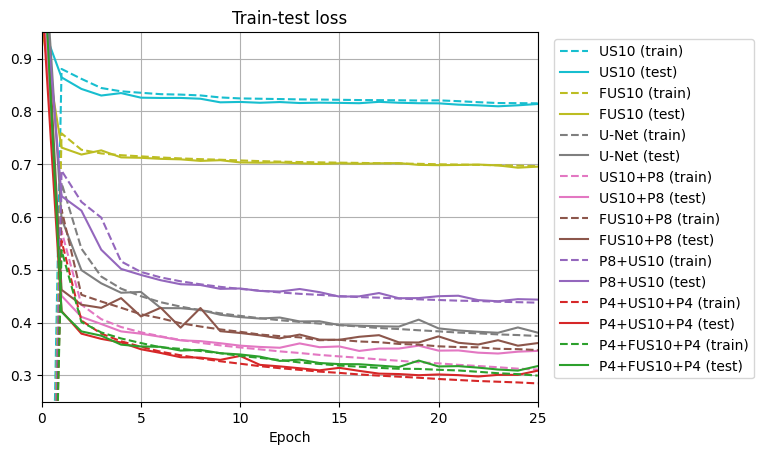

In [7]:
MAX_EPOCH = 25

# available metrics: 'LOSS', 'MSE', 'MAE', 'LPIPS_Vgg', 'LPIPS_Alex', 'PSNR', 'SSIM', 'ReconstructionError'
selected_metrics = ["PSNR", "SSIM", "LPIPS_Vgg"]

# plot train and test loss
import matplotlib.colors as mcolors
plot_colors = list(mcolors.TABLEAU_COLORS.keys())
plt.figure()
for key, value in model_paths.items():
    _metrics_path = os.path.join(value, "metrics.json")
    assert os.path.exists(_metrics_path), f"Path {_metrics_path} does not exist"
    _test_metrics = json.load(open(_metrics_path))

    color = plot_colors.pop()
    train_loss = np.array(_test_metrics["LOSS"])
    train_loss = train_loss[:MAX_EPOCH+1]
    plt.plot(train_loss, label=key + " (train)", color=color, linestyle="--")

    test_loss = np.array(_test_metrics["MSE"]) + np.array(_test_metrics["LPIPS_Vgg"])
    test_loss = test_loss[:MAX_EPOCH+1]
    plt.plot(test_loss, label=key + " (test)", linestyle="-", color=color)

    best_epoch = np.argmin(test_loss)
    print(f"\n-- {key} --")
    print(f"Best epoch (chosen from test loss): {best_epoch} / {len(test_loss)-1}")

    # print metrics
    for _metric in selected_metrics:
        print(f"{_metric}: {np.array(_test_metrics[_metric])[best_epoch]:.3}")

    print(f"Best test loss: {test_loss[best_epoch]:.3}")

plt.xlabel("Epoch")
plt.title("Train-test loss")

# legend outside
plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1.0))
plt.ylim([0.25, 0.95]);
plt.xlim([0, MAX_EPOCH])
# plt.legend()
plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1.0))

plt.grid()

Plot metric over iterations


PSNR
--------------------------------------------------------------------------------
Max PSNR for US10 (epoch 4): 9.15
Max PSNR for FUS10 (epoch 25): 11.6
Max PSNR for U-Net (epoch 25): 18.0
Max PSNR for US10+P8 (epoch 24): 20.1
Max PSNR for FUS10+P8 (epoch 25): 19.3
Max PSNR for P8+US10 (epoch 29): 16.8
Max PSNR for P4+US10+P4 (epoch 23): 21.8
Max PSNR for P4+FUS10+P4 (epoch 25): 21.3

SSIM
--------------------------------------------------------------------------------
Max SSIM for US10 (epoch 3): 0.329
Max SSIM for FUS10 (epoch 23): 0.436
Max SSIM for U-Net (epoch 25): 0.596
Max SSIM for US10+P8 (epoch 24): 0.66
Max SSIM for FUS10+P8 (epoch 22): 0.635
Max SSIM for P8+US10 (epoch 29): 0.525
Max SSIM for P4+US10+P4 (epoch 25): 0.688
Max SSIM for P4+FUS10+P4 (epoch 25): 0.678

LPIPS_Vgg
--------------------------------------------------------------------------------
Min LPIPS_Vgg for US10 (epoch 25): 0.669
Min LPIPS_Vgg for FUS10 (epoch 24): 0.623
Min LPIPS_Vgg for U-Net (epoch 23): 

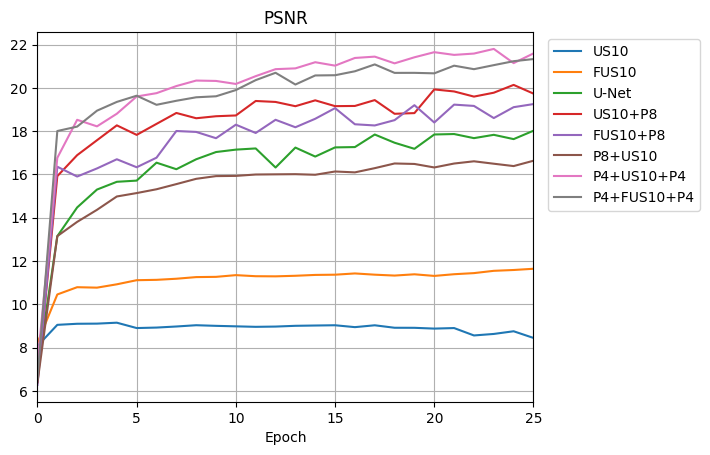

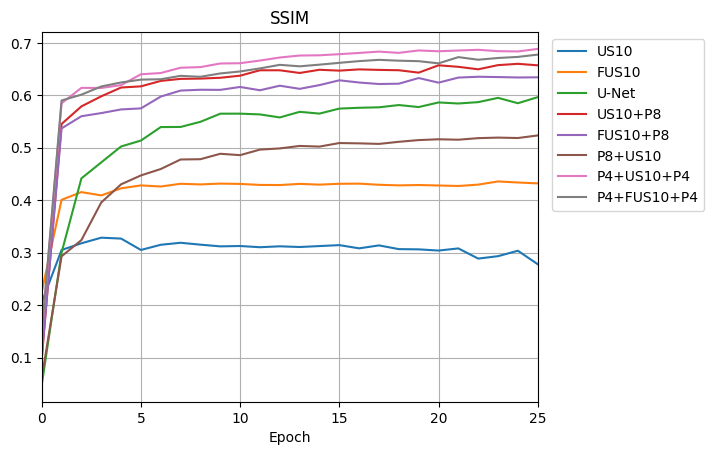

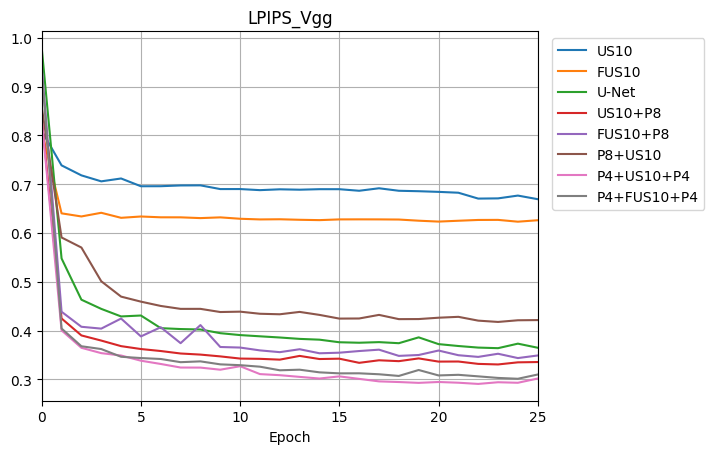

In [8]:
# metrics: 'LOSS', 'MSE', 'MAE', 'LPIPS_Vgg', 'LPIPS_Alex', 'PSNR', 'SSIM', 'ReconstructionError'
for metric in selected_metrics:
    print(f"\n{metric}")
    print("-" * 80)

    plt.figure()
    for key, value in model_paths.items():
        _metrics_path = os.path.join(value, "metrics.json")
        assert os.path.exists(_metrics_path), f"Path {_metrics_path} does not exist"
        _test_metrics = json.load(open(_metrics_path))

        _test_metrics = np.array(_test_metrics[metric])
        plt.plot(_test_metrics, label=key)

        # print three significant digits
        if metric == "PSNR" or metric == "SSIM":
            
            print(f"Max {metric} for {key} (epoch {np.argmax(_test_metrics)}): {np.max(_test_metrics):.3}")
        else:
            print(f"Min {metric} for {key} (epoch {np.argmin(_test_metrics)}): {np.min(_test_metrics):.3}")

    plt.xlabel("Epoch")
    plt.title(metric)
    plt.grid()
    plt.xlim(0, MAX_EPOCH)
    plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0))

Let's look at some reconstructions! First we'll load the models.

In [9]:
from lensless.recon.model_dict import load_model

models = dict()
for key, value in model_paths.items():
    models[key] = load_model(value, psf=dataset.psf, device=torch_device)


Now like before, we can compare reconstructions for a specific index.

In [10]:
_recon.shape

(262, 215, 3)

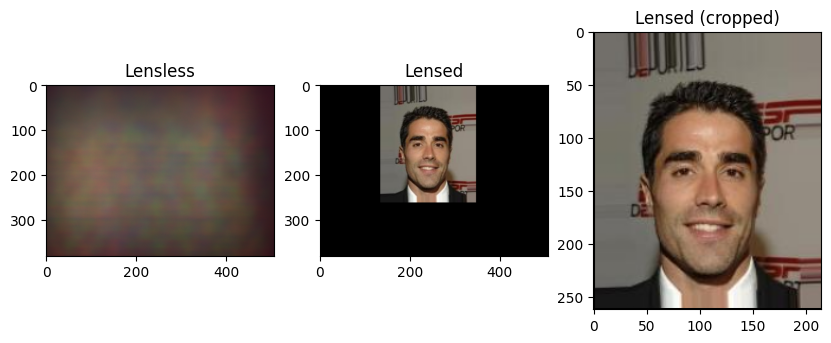

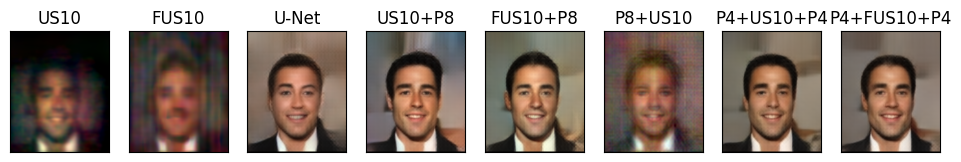

In [13]:
idx = 4
lensless, lensed = test_set[idx]
recon = dict()   # store reconstructions

# extract region of interest
crop = dataset.crop
lensed = lensed.squeeze()
if crop is not None:
    lensed_cropped = lensed[
        ...,
        crop["vertical"][0] : crop["vertical"][1],
        crop["horizontal"][0] : crop["horizontal"][1],
        :,
    ]

# loop over algorithms and number of iterations
for algo, _model in models.items():

    with torch.no_grad():
        _model.set_data(lensless.to(torch_device))
        res = _model.apply(
            disp_iter=-1,
            save=False,
            gamma=None,
            plot=False,
        )

    _recon = res[0]
    _recon = _recon.reshape(-1, *_recon.shape[-3:]).movedim(-1, -3)
    if crop is not None:
        _recon = _recon[
            ...,
            crop["vertical"][0] : crop["vertical"][1],
            crop["horizontal"][0] : crop["horizontal"][1],
        ]
    _recon = _recon.cpu().numpy().squeeze()
    _recon = np.moveaxis(_recon, 0, -1)

    # -- save
    recon[algo] = _recon
    with torch.no_grad():
        _model.reset()

# plot
# -- lensless and lensed
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(lensless.cpu().numpy().squeeze())
ax[0].set_title("Lensless")
ax[1].imshow(lensed)
ax[1].set_title("Lensed")
ax[2].imshow(lensed_cropped)
ax[2].set_title("Lensed (cropped)")

# -- reconstructions
fig, ax = plt.subplots(1, len(models.keys()), figsize=(12, 6.5))
for i, algo in enumerate(models.keys()):
    plot_image(recon[algo], ax=ax[i])
    ax[i].set_title(f"{algo}")
    # remove ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## Section 4.3 (Learning mask)

The purpose of this experiment is to jointly learn the physical mask and digital reconstruction parameters through *hardware-in-the-loop* (HITL) training. For this experiment, the data has to be re-simulated / re-measured whenever the mask pattern changes.